In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Dict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm.auto import tqdm
tqdm.pandas()
import json

from sklearn.metrics import accuracy_score
from scipy import stats

from model import Model
from one_hot_dataset import OneHotDataset

import pickle

In [2]:
with open('index_to_family_label_dict.pkl', 'rb') as f:
    index_to_family_label_dict = pickle.load(f)

index_to_family_label_dict contains the mapping of index Pfam accession - important for the analysis later. Also, get the reverse dictionary.

In [3]:
family_label_to_index_dict = {v:k for k, v in index_to_family_label_dict.items()}

### We will later also need the processed dataframes that were used for generation of the training and test data

In [4]:
train_df = pd.read_csv('processed_df/train.csv', ).reset_index(drop=True)
test_df = pd.read_csv('processed_df/test.csv', ).reset_index(drop=True)

In [5]:
train_df.head(2)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_length
0,Rtt106,POB3_CANAL/362-454,PF08512.12,AGVPCSVKA...SEGYLFPL......DRCFLF.VTKPTLYIPYSE....,AGVPCSVKASEGYLFPLDRCFLFVTKPTLYIPYSEISSVVMSRTGG...,93
1,HupF_HypC,O28902_ARCFU/1-65,PF01455.18,MCIAIPGR...I.ER..IDY...............P....IAIVDF...,MCIAIPGRIERIDYPIAIVDFKGLKKEVRIDLLENPQIGDYVLVHV...,65


### Get the maximum percent sequence identity between a sequence in the test set and any sequence in the training set.
In addition, save the family with which the maximum sequence identity match was found. This analysis could be done with something like the top 5 (or whatever) average sequence identities, I will use the top 1 in this case.

In [6]:
def compute_percent_sequence_identity(sequence: str,
                                      train_df: pd.DataFrame) -> Tuple[float, str]:
    """
    Computes the maximum percent sequence identity between a protein
            sequence and any protein sequence in the training DataFrame.

    Args:
     sequence (str): the protein sequence to compare.
     train_df (pd.DataFrame): the Pfam seed training df. Must already have the seq_length column.

    Returns:
     max_identity (float) the maximum sequence identity 
     max_identity_fam_accession (float): the family accession corresponding to the
             sequence that achieved this maximum identity.

    """
    assert 'seq_length' in train_df.columns, "The 'seq_length' column with the sequence lengths must exist in train_df."
    seq_length = len(sequence)
    # Get all the sequences with the same length as the input sequence
    train_sequences, train_family_accessions = train_df.loc[train_df['seq_length'] == seq_length][['sequence', 'family_accession']].values.T
    max_identity = 0.
    max_identity_fam_accession = ""
    for train_seq, train_fam_access in zip(train_sequences,train_family_accessions):
        # Compute sequence identity
        identity = sum(a == b for a, b in zip(sequence, train_seq)) / seq_length
        # Update max identity if necessary
        if identity > max_identity:
            max_identity = identity
            max_identity_fam_accession = train_fam_access
    return (max_identity, max_identity_fam_accession)

In [7]:
list_of_tuples = test_df['sequence'].progress_apply(lambda seq: compute_percent_sequence_identity(seq, train_df))

  0%|          | 0/64417 [00:00<?, ?it/s]

In [8]:
test_df['max_seq_identity'], test_df['pfam_max_seq_identity'] = zip(*list_of_tuples)

In [9]:
test_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_length,max_seq_identity,pfam_max_seq_identity
0,DnaJ_C,M4V8X0_9PROT/126-339,PF01556.18,LRFITEIELEEVISG.K.E.....AQI......EF..............,LRFITEIELEEVISGKEAQIEFDTEANCDDCNGSGAAKGSSATTCP...,214,0.607477,PF01556.18
1,HisKA,Q55475_SYNY3/177-241,PF00512.25,QRRELVSDLTHELRSPLTVVRGYLEQ.L..AE.................,QRRELVSDLTHELRSPLTVVRGYLEQLAEGTIAGDPELYQRLVGET...,65,0.400000,PF00512.25
2,OppC_N,F7IVL3_TREDE/18-73,PF12911.7,SPA.QQI..R.....I...KFRNNRLAMMGFYMFVT.IVL.L.......,SPAQQIRIKFRNNRLAMMGFYMFVTIVLLVVVTHFYTKFTGYDFAK...,56,0.285714,PF12911.7
3,DUF1400,K9VGC5_9CYAN/34-159,PF07176.11,AAQTVVV.RKGIL.ESS...ISVADLRELAET...GKVPAKLQAYA...,AAQTVVVRKGILESSISVADLRELAETGKVPAKLQAYANLLSDEQR...,126,0.523810,PF07176.11
4,SpaA,R7KCV1_9CLOT/520-587,PF17802.1,KTNT..IL..AGATLKVI...NK..........................,KTNTILAGATLKVINKDTSEVIDTFVTTTTGHSIKGLKAGTYKVIE...,68,0.338235,PF17802.1


## See how many mismatches there are, i.e. how many test sequences have their maximum identity match in the training dataset in a different Pfam. This will be our baseline maximum sequence identity classifier (MSIC) with the training set, i.e. the label of the sequence is predicted as the labels of the exampple of maximum sequence identity in the training set.
Essentially, we can later see if our method performs better than this "dummy" classifier, whihch predicts the nearest neighbour in terms of sequence identity and we can see if the mistakes our model made

In [10]:
test_df['misclassified_by_dummy_msic'] = test_df['family_accession'] != test_df['pfam_max_seq_identity']

In [11]:
test_df['misclassified_by_dummy_msic'].sum() 

3859

In [12]:
test_df['misclassified_by_dummy_msic'].sum()  / len(test_df)

0.05990654640855675

## Essentially, this means that a maximum sequence identity classifier (MSIC) reaches a 6% error
### We can check the distribution of maximum sequence identities of the misclassified samples compared to the overall maximum sequence identity distribution

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

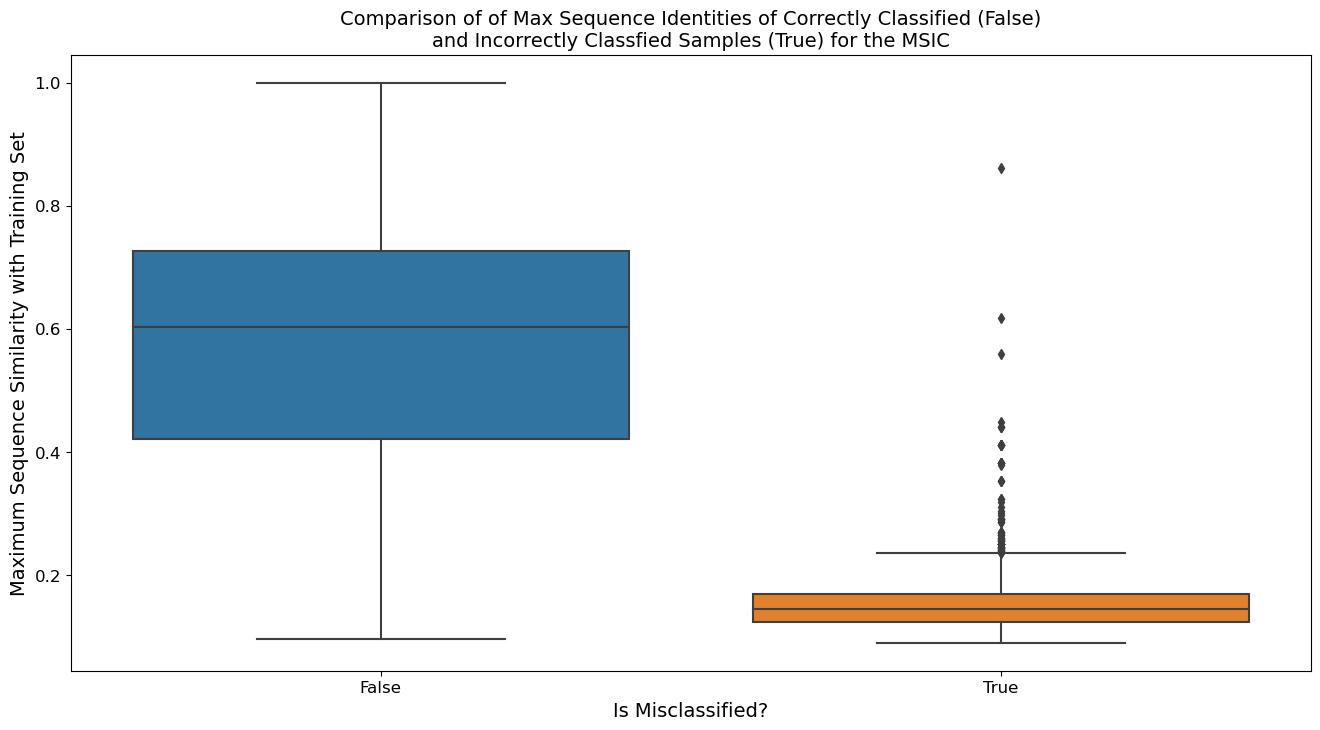

In [13]:
fig, ax = plt.subplots(figsize = (16,8))
sn.boxplot(data=test_df, y='max_seq_identity', x='misclassified_by_dummy_msic', ax=ax)
plt.xlabel('Is Misclassified?', fontdict={'fontsize':14})
plt.ylabel('Maximum Sequence Similarity with Training Set', fontdict={'fontsize':14})
plt.title('Comparison of of Max Sequence Identities of Correctly Classified (False)\nand Incorrectly Classfied Samples (True) for the MSIC', fontdict={'fontsize':14})
plt.xticks(size=12)
plt.yticks(size=12)

# Obviously, the misclassified samples by the MSIC have a low max sequence identity with the training set overall

In [14]:
# Additionally, later we will need the confidences in prediction of the MSIC dummy,
# which is the max sequence identity with the training set for every example
prediction_confidences_msic = test_df['max_seq_identity'].values

## Load the test data that was obtained previously to conduct inference and analysis of the results

In [15]:
with open('sparse_one_hot_data/test.pkl', 'rb') as f:
    one_hot_sequences_test = pickle.load(f)
with open('sparse_one_hot_data/test_labels.pkl', 'rb') as f:
    one_hot_labels_test = pickle.load(f)

In [16]:
with open('hparams.json', 'r') as json_file:
    hparams = json.load(json_file)

In [17]:
one_hot_sequences_test.shape

(64417,)

## Normally, for inference the loader would not be necessary, but we need it because the data is in sparse format and we need to unpack it
Obviously, there are ways to skip the loader in this case, too but the number of lines of code is similar 

In [18]:
test_ds = OneHotDataset(one_hot_sequences_test, one_hot_labels_test)
test_dl = DataLoader(test_ds, batch_size=hparams['batch_size']) # it is essential that we don't shuffle as later the indices will be important

In [19]:
# the inference here will be local, but still get the device in the usual way
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
model = Model(in_channels=one_hot_sequences_test[0].shape[1],
              out_channels=hparams['filters'],
              input_length=one_hot_sequences_test[0].shape[0],
             out_features=one_hot_labels_test.shape[1]).to(device)

## Load the trained model (trained in Kaggle)

In [21]:
model.load_state_dict(torch.load('trained_model/best_model_filters_100.pt', map_location=device))

<All keys matched successfully>

## Redefine the training step because we want to return also the predictions and analyse them

In [22]:
def test_step(model: nn.Module,
              loader: DataLoader,
              device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    """
    Evaluate the model on the given data for one epoch.

    Args:
        model (nn.Module): the neural network model to be evaluated
        loader (data.DataLoader): the data loader object that provides the test data
        device (torch.device): the device where the computation is performed (CPU or GPU)

    Returns:
        The true labels and predictions.
    """

    model.eval()  # set the model in evaluation mode
    labels = []
    predictions = []
    with torch.no_grad():
        for i, (batch_oh_sequences, batch_oh_labels) in tqdm(enumerate(loader)):
            # move the batch data to the device
            batch_oh_sequences = batch_oh_sequences.permute(0, 2, 1).to(device=device)
            batch_oh_labels = torch.squeeze(batch_oh_labels, dim=1)
            # forward pass
            preds = model(batch_oh_sequences)
            
            labels.append(batch_oh_labels.cpu().numpy())
            predictions.append(preds.cpu().numpy())

    return np.concatenate(labels, axis=0), np.concatenate(predictions, axis=0)

In [23]:
labels, predictions = test_step(model, test_dl, device)

0it [00:00, ?it/s]

In [24]:
labels.shape, predictions.shape

((64417, 1616), (64417, 1616))

## As a first step - get the overall accuracy
### To do this, first convert the predictions to binary

In [25]:
binary_predictions = np.array([np.where(pred == np.max(pred), 1., 0.) for pred in predictions])

In [26]:
binary_predictions.shape

(64417, 1616)

In [27]:
accuracy_score(labels, binary_predictions)

0.9687504851203875

## This means we have a 96.9% accuracy on the test set overall. This means our model has 3.1% error rate which is lower than that of the MSIC dummy classifier (above), but we need to determine whether this difference is statistically significant.

In [28]:
# get the prediction scores that our model gives
prediction_confidences = np.max(predictions, axis=1)

In [29]:
# conduct a t-test to see if the two models are statistically significantly different
t_test, p_val = stats.ttest_rel(prediction_confidences, prediction_confidences_msic)

In [30]:
print('The value of the t-test is: ', t_test,  ' and its p-value is: ',  p_val)

The value of the t-test is:  542.4978509738828  and its p-value is:  0.0


### Essentially, this means that the model did not turn into the dummy classifier. However, we still need to determine whether the difference in errors between the two is stitistically significant. We can do this via a McNemar test (as in Bileschi et al.).

The McNemar test is a statistical significance test used to compare two paired proportions (the corresponding chi-square test for paired data). It is often used to compare the performance of two classifiers on the same dataset. The test is based on a contingency table with two rows and two columns. The first row represents the number of instances that were classified correctly by the first classifier but not by the second, while the second row represents the number of instances that were classified correctly by the second classifier but not by the first. The test evaluates whether there is a significant difference between these two proportions.

The null hypothesis of the McNemar test is that the two classifiers have the same proportion of correct classifications. The alternative hypothesis is that the two classifiers have different proportions of correct classifications. The test statistic for McNemar's test is calculated as follows:

In [31]:
# the contingency table will have corrctly and incorrectly classified by both on the diagonal and the different ones on the off-diagonal
# Thus, first get the predictions by the model in a dataframe with the "misclassified" column
predicted_family_idx = prediction_confidences = np.argmax(predictions, axis=1)
predicted_pfam = np.array([index_to_family_label_dict[idx] for idx in predicted_family_idx])

In [32]:
test_df['model_prediction'] = predicted_pfam

In [33]:
# get a column with misclassifications by the model
test_df['misclassified_by_model'] = test_df['model_prediction'] != test_df['family_accession']

In [34]:
# number of misclassifications by model
test_df['misclassified_by_model'].sum()

2013

In [35]:
test_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_length,max_seq_identity,pfam_max_seq_identity,misclassified_by_dummy_msic,model_prediction,misclassified_by_model
0,DnaJ_C,M4V8X0_9PROT/126-339,PF01556.18,LRFITEIELEEVISG.K.E.....AQI......EF..............,LRFITEIELEEVISGKEAQIEFDTEANCDDCNGSGAAKGSSATTCP...,214,0.607477,PF01556.18,False,PF01556.18,False
1,HisKA,Q55475_SYNY3/177-241,PF00512.25,QRRELVSDLTHELRSPLTVVRGYLEQ.L..AE.................,QRRELVSDLTHELRSPLTVVRGYLEQLAEGTIAGDPELYQRLVGET...,65,0.400000,PF00512.25,False,PF00512.25,False
2,OppC_N,F7IVL3_TREDE/18-73,PF12911.7,SPA.QQI..R.....I...KFRNNRLAMMGFYMFVT.IVL.L.......,SPAQQIRIKFRNNRLAMMGFYMFVTIVLLVVVTHFYTKFTGYDFAK...,56,0.285714,PF12911.7,False,PF12911.7,False
3,DUF1400,K9VGC5_9CYAN/34-159,PF07176.11,AAQTVVV.RKGIL.ESS...ISVADLRELAET...GKVPAKLQAYA...,AAQTVVVRKGILESSISVADLRELAETGKVPAKLQAYANLLSDEQR...,126,0.523810,PF07176.11,False,PF07176.11,False
4,SpaA,R7KCV1_9CLOT/520-587,PF17802.1,KTNT..IL..AGATLKVI...NK..........................,KTNTILAGATLKVINKDTSEVIDTFVTTTTGHSIKGLKAGTYKVIE...,68,0.338235,PF17802.1,False,PF17802.1,False


In [36]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0%-10%', '10%-20%', '20%-30%', '30%-40%', '40%-50%', '50%-60%', '60%-70%', '70%-80%', '80%-90%', '90%-100%']
test_df['binned_seq_identities'] = pd.cut(test_df['max_seq_identity'], bins, labels=bin_labels)

## Get the error rate per bin for both

In [37]:
def get_error_rate_per_bin(df: pd.DataFrame,
                           bin_column: str,
                           misclassified_col: str) -> Dict[str, float]:
    """Computes the error rate per bin for a given DataFrame.

    Args:
        df (pd.DataFrame): Must have misclassifications and binned sequence identity columns already created.
        bin_column (str): The column name of the binned sequence identity variable in the DataFrame.
        misclassified_col (str): The column name of the binary variable that indicates whether a sample is misclassified.

    Returns:
        bin_label_to_error_rates (dict): A dictionary mapping each bin label to its error rate.
    """
    # Get the unique bin labels from the bin_column, sorting works well for the current string labelling
    bin_labels = sorted(df[bin_column].unique())
    
    # Compute the error rate for each bin
    bin_label_to_error_rates = {}
    for bin_label in bin_labels:
        tmp_df = df.loc[df[bin_column] == bin_label]
        error_rate = sum(tmp_df[misclassified_col]) / len(tmp_df)
        bin_label_to_error_rates[bin_label] = error_rate
    
    return bin_label_to_error_rates

In [38]:
model_error_rate_per_bin = get_error_rate_per_bin(test_df, 'binned_seq_identities', 'misclassified_by_model')

In [39]:
msic_dummy_error_rate_per_bin = get_error_rate_per_bin(test_df, 'binned_seq_identities', 'misclassified_by_dummy_msic')

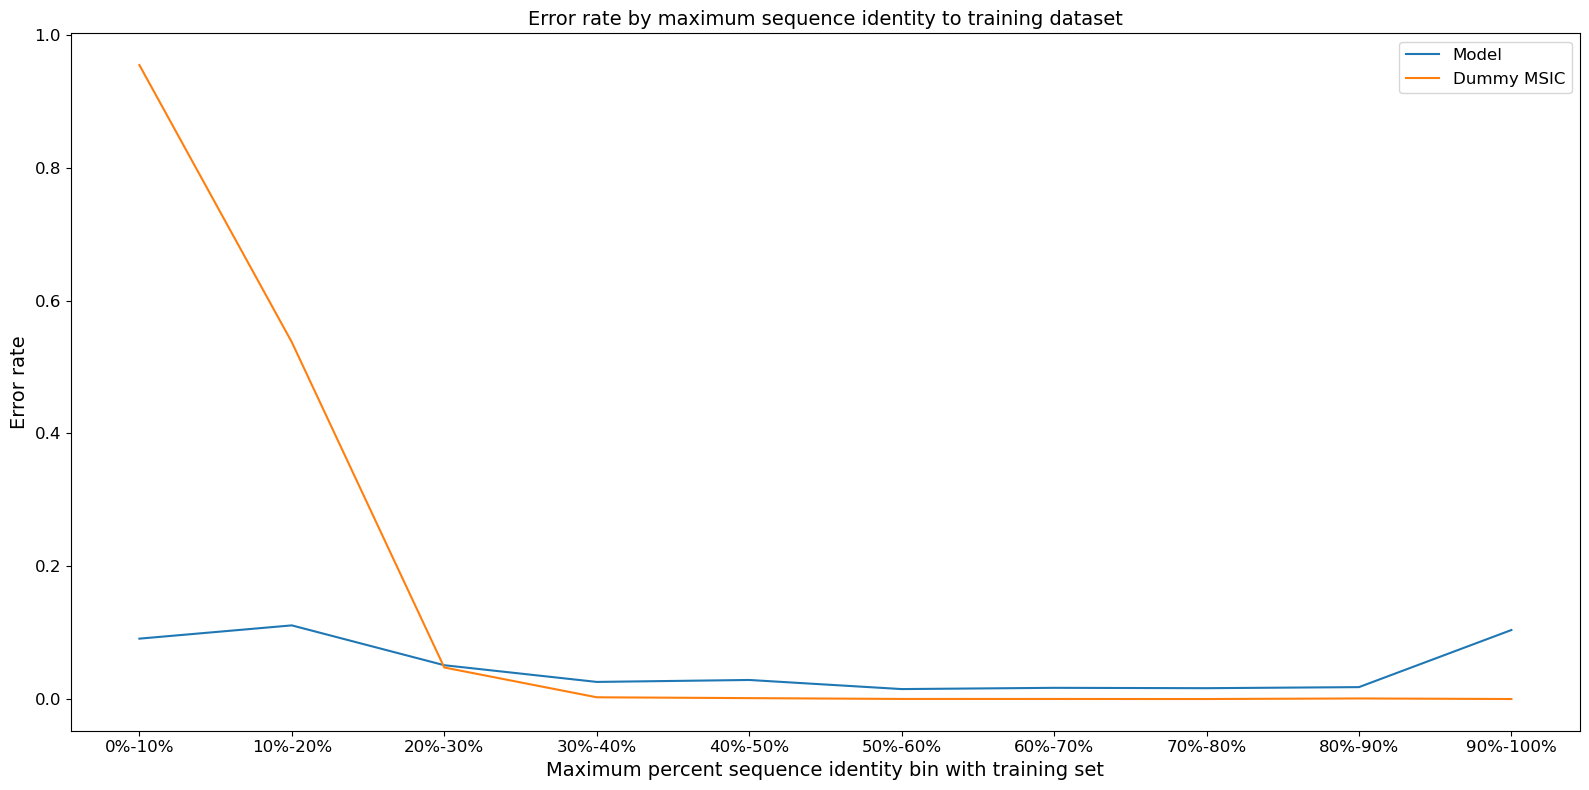

In [40]:
fig, ax = plt.subplots(figsize = (16,8))
sn.lineplot(y=model_error_rate_per_bin.values(), x=model_error_rate_per_bin.keys(), label='Model')
sn.lineplot(y=msic_dummy_error_rate_per_bin.values(), x=msic_dummy_error_rate_per_bin.keys(), label='Dummy MSIC')
plt.xlabel('Maximum percent sequence identity bin with training set', fontdict={'fontsize':14})
plt.ylabel('Error rate', fontdict={'fontsize':14})
plt.title('Error rate by maximum sequence identity to training dataset', fontdict={'fontsize':14})
plt.legend(fontsize=12, title_fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()

In [41]:
def get_contingency_table(df: pd.DataFrame,
                          key_misclassified_by_model: str = 'misclassified_by_model',
                          key_misclassified_by_benchmark: str = 'misclassified_by_dummy_msic') -> np.ndarray:
    """
    Constructs a contingency table from a dataframe with misclassification columns.
    
    Args:
     df (pd.DataFrame): The input data.
     key_misclassified_by_model (str): The column key for the misclassified by a proposed model field in df.
     key_misclassified_by_benchmark (str): The column key for the misclassified by the benchmark model field in df.
    
    Returns:
     contingency_table (np.ndarray): A 2x2 numpy array containing the contingency table.
    """
    
    # Create boolean masks for each possible combination of correct/incorrect classification.
    both_correct = ~df[key_misclassified_by_model] & ~df[key_misclassified_by_benchmark]
    both_incorrect = df[key_misclassified_by_model] & df[key_misclassified_by_benchmark]
    model_correct_only = ~df[key_misclassified_by_model] & df[key_misclassified_by_benchmark]
    dummy_correct_only = df[key_misclassified_by_model] & ~df[key_misclassified_by_benchmark]
    
    # Initialize the contingency table with zeros.
    contingency_table = np.zeros(shape=[2, 2])
    
    # Fill in the contingency table.
    contingency_table[0, 0] = len(df.loc[both_correct])
    contingency_table[0, 1] = len(df.loc[model_correct_only])
    contingency_table[1, 0] = len(df.loc[dummy_correct_only])
    contingency_table[1, 1] = len(df.loc[both_incorrect])
    
    return contingency_table

In [42]:
def get_p_value_of_mcnemar(contingency_table: np.ndarray) -> float:
    """
    Compute the p-value for the McNemar test given a 2x2 contingency table.

    Parameters:
     contingency_table (np.ndarray): A 2x2 contingency table.

    Returns:
     p_value_of_two_sided_mcnemar (float): The p-value for the McNemar test.

    """
    b = contingency_table[0, 1]
    c = contingency_table[1, 0]

    mcnemar_test_statistic_value = ((b-c) ** 2) / (b + c)

    # two-sided because the difference is squared, so we will only see if the difference is significant
    # not in favour of whom. We will see which is better in the plots
    p_value_of_two_sided_mcnemar = 1 - stats.chi2.cdf(mcnemar_test_statistic_value, 1)

    return p_value_of_two_sided_mcnemar

In [43]:
def get_statistical_significance_of_difference_per_bin(
    df: pd.DataFrame,
    bin_column: str,
    key_misclassified_by_model: str,
    key_misclassified_by_benchmark: str) -> Tuple[Dict[str, float], Dict[str, int]]:
    """
    Calculate statistical significance of the difference between the model and benchmark
    misclassifications within each bin using McNemar's test.
    
    Args:
     df (pd.DataFrame): containing the data
     bin_column (str): name of the column containing the bin labels
     key_misclassified_by_model (str): name of the column containing model misclassification labels
     key_misclassified_by_benchmark (str): name of the column containing benchmark misclassification labels
        
    Returns:
     bin_label_to_p_val (dict): dictionary mapping bin labels to p-values for McNemar's test
     num_of_examples_considered (dict): dictionary mapping bin labels to the number of examples in that bin
    """
    # Get unique bin labels
    bin_labels = sorted(df[bin_column].unique())
    
    # Initialize dictionaries to store results
    bin_label_to_p_val = {}
    num_of_examples_considered = {}
    
    # Loop over each bin label
    for bin_label in bin_labels:
        tmp_df = df.loc[df[bin_column] == bin_label]
        
        # Get contingency table for McNemar's test
        cont_table = get_contingency_table(tmp_df, key_misclassified_by_model, key_misclassified_by_benchmark)
        
        # Calculate p-value for McNemar's test
        bin_label_to_p_val[bin_label] = get_p_value_of_mcnemar(cont_table)
        
        # Store number of examples considered for this bin
        num_of_examples_considered[bin_label] = len(tmp_df)
        
    return bin_label_to_p_val, num_of_examples_considered

In [44]:
bin_label_to_p_val, num_of_examples_considered =\
    get_statistical_significance_of_difference_per_bin(test_df, 'binned_seq_identities', 'misclassified_by_model', 'misclassified_by_dummy_msic')

In [45]:
for bin_label in bin_label_to_p_val.keys():
    print('For the bin: ', bin_label, ' the p-value of the two-sided McNemar test is ',\
      round(bin_label_to_p_val[bin_label], 4), ' this is for ', num_of_examples_considered[bin_label], ' sequences')

For the bin:  0%-10%  the p-value of the two-sided McNemar test is  0.0  this is for  66  sequences
For the bin:  10%-20%  the p-value of the two-sided McNemar test is  0.0  this is for  6548  sequences
For the bin:  20%-30%  the p-value of the two-sided McNemar test is  0.3809  this is for  5266  sequences
For the bin:  30%-40%  the p-value of the two-sided McNemar test is  0.0  this is for  5748  sequences
For the bin:  40%-50%  the p-value of the two-sided McNemar test is  0.0  this is for  7426  sequences
For the bin:  50%-60%  the p-value of the two-sided McNemar test is  0.0  this is for  8950  sequences
For the bin:  60%-70%  the p-value of the two-sided McNemar test is  0.0  this is for  11628  sequences
For the bin:  70%-80%  the p-value of the two-sided McNemar test is  0.0  this is for  17459  sequences
For the bin:  80%-90%  the p-value of the two-sided McNemar test is  0.0  this is for  1172  sequences
For the bin:  90%-100%  the p-value of the two-sided McNemar test is  0

## Hence, all the differences are significant, except for the 20%-30% sequence identity bin. Moreover, the model is only significantly better in the cases where the max sequence identity is lowest. Essentially, this means that the model was able to actually capture more than just the sequence identity. However, it seems that it makes poorer predictions when the sequences become more similar to those in the training set. This may indicate that the model is underfitting, because it hasn't been able to capture a relationship such as the maximum percent sequence identity, even though it has captured other dependencies. On top of that, the curve for the model is quite smooth - again pointing to the same conclusion, but more importantly, it increases in the bin with the highest sequence identity (to basically the same value as the lowest identity bins), which again points to the model missing a relationship which is so obvious to us.

### Otherwise, the plot looks as expected, as both make better predictions when the similarity to the training set is higher (except for the last bin as discussed above).

## However, why did we get 3.1% of the labels wrong? Where did our model make mistakes? Need to work on explainability. One way to do this is via a method such as CAM (10.1109/CVPR.2016.319). However, time is quite limited now, so I will try something simpler.

Let's see if there is any pattern between the misclassifications

In [46]:
test_df.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_length,max_seq_identity,pfam_max_seq_identity,misclassified_by_dummy_msic,model_prediction,misclassified_by_model,binned_seq_identities
0,DnaJ_C,M4V8X0_9PROT/126-339,PF01556.18,LRFITEIELEEVISG.K.E.....AQI......EF..............,LRFITEIELEEVISGKEAQIEFDTEANCDDCNGSGAAKGSSATTCP...,214,0.607477,PF01556.18,False,PF01556.18,False,60%-70%
1,HisKA,Q55475_SYNY3/177-241,PF00512.25,QRRELVSDLTHELRSPLTVVRGYLEQ.L..AE.................,QRRELVSDLTHELRSPLTVVRGYLEQLAEGTIAGDPELYQRLVGET...,65,0.400000,PF00512.25,False,PF00512.25,False,30%-40%
2,OppC_N,F7IVL3_TREDE/18-73,PF12911.7,SPA.QQI..R.....I...KFRNNRLAMMGFYMFVT.IVL.L.......,SPAQQIRIKFRNNRLAMMGFYMFVTIVLLVVVTHFYTKFTGYDFAK...,56,0.285714,PF12911.7,False,PF12911.7,False,20%-30%
3,DUF1400,K9VGC5_9CYAN/34-159,PF07176.11,AAQTVVV.RKGIL.ESS...ISVADLRELAET...GKVPAKLQAYA...,AAQTVVVRKGILESSISVADLRELAETGKVPAKLQAYANLLSDEQR...,126,0.523810,PF07176.11,False,PF07176.11,False,50%-60%
4,SpaA,R7KCV1_9CLOT/520-587,PF17802.1,KTNT..IL..AGATLKVI...NK..........................,KTNTILAGATLKVINKDTSEVIDTFVTTTTGHSIKGLKAGTYKVIE...,68,0.338235,PF17802.1,False,PF17802.1,False,30%-40%


In [47]:
misclassified_df = test_df.loc[test_df['misclassified_by_model']][['family_accession', 'model_prediction']].\
    rename(mapper={'family_accession': 'true', 'model_prediction':'predicted'}, axis=1)

### In some cases there have been more than one misclassifications per class, i.e. multiple samples from one class were miclassified as another class

In [48]:
# get all duplicated samples
duplicated_misclassifications = misclassified_df.loc[misclassified_df.duplicated(['true', 'predicted'], keep=False)].sort_values('predicted')

In [49]:
duplicated_misclassifications

,true,predicted
29556,PF04647.15,PF00003.22
19906,PF06912.11,PF00003.22
24039,PF06912.11,PF00003.22
9819,PF04647.15,PF00003.22
5833,PF12797.7,PF00037.27
...,...,...
57307,PF13634.6,PF17802.1
17148,PF13634.6,PF17802.1
45426,PF13634.6,PF17802.1
24595,PF07219.13,PF17937.1


In [50]:
# count all misclassified pairs
misclassified_pairs_count = misclassified_df[['predicted', 'true']]\
    .groupby(['predicted', 'true']).value_counts().sort_values(ascending=False)

In [51]:
misclassified_pairs_count.head(10)

predicted   true      
PF13405.6   PF00036.32    55
PF07719.17  PF00515.28    54
PF12798.7   PF10576.9     47
PF12874.7   PF13894.6     31
PF09527.10  PF04066.13    21
PF00037.27  PF12797.7     19
PF00095.21  PF00219.18    19
PF12661.7   PF02810.15    18
PF07811.12  PF13400.6     17
PF12661.7   PF13240.6     15
dtype: int64

In [52]:
test_df.loc[test_df['family_accession'] == 'PF00036.32'].head(1)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_length,max_seq_identity,pfam_max_seq_identity,misclassified_by_dummy_msic,model_prediction,misclassified_by_model,binned_seq_identities
103,EF-hand_1,FILA_HUMAN/53-81,PF00036.32,MVDVFMDHLDIDHNKKIDFTEFLLMVFKL,MVDVFMDHLDIDHNKKIDFTEFLLMVFKL,29,0.482759,PF00036.32,False,PF13405.6,True,40%-50%


In [53]:
test_df.loc[test_df['family_accession'] == 'PF13405.6'].head(1)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_length,max_seq_identity,pfam_max_seq_identity,misclassified_by_dummy_msic,model_prediction,misclassified_by_model,binned_seq_identities
1168,EF-hand_6,B5Y4Q9_PHATC/86-115,PF13405.6,EIQ..KVFDLF.D.EG...RKG..HINVQDL.RN..AST..........,EIQKVFDLFDEGRKGHINVQDLRNASTGLG,30,0.533333,PF13405.6,False,PF13405.6,False,50%-60%


EF-hand_1 and EF-hand_6 are probably close families, and the sequence lengths also look similar. So, it is likely that our model capture the similarity even between families and that is why the misclassification occured. In order to be more sure of this, more tests, including explaing the filter activations would be needed in order to conclude this with more certainty.